In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 96% 651M/675M [00:01<00:00, 277MB/s]
100% 675M/675M [00:01<00:00, 371MB/s]


In [4]:
!unzip -q cell-images-for-detecting-malaria.zip -d malaria_data

In [5]:
import os

print(os.listdir("malaria_data"))
print(os.listdir("malaria_data/cell_images"))

['cell_images']
['cell_images', 'Parasitized', 'Uninfected']


In [6]:
!rm -r /content/malaria_data/cell_images/cell_images

In [7]:
import glob, os

parasitized = glob.glob("/content/malaria_data/cell_images/Parasitized/*.png")
uninfected  = glob.glob("/content/malaria_data/cell_images/Uninfected/*.png")

print("Parasitized:", len(parasitized))
print("Uninfected :", len(uninfected))
print("Total      :", len(parasitized) + len(uninfected))

Parasitized: 13779
Uninfected : 13779
Total      : 27558


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler


import os
print(os.listdir('/content/malaria_data/cell_images/'))

['Parasitized', 'Uninfected']


In [9]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])

In [10]:
DATASET_ROOT = "/content/malaria_data/cell_images/"

dataset = datasets.ImageFolder(DATASET_ROOT, transform=train_transforms)

print("Classes:", dataset.classes)
print("Total images:", len(dataset))

Classes: ['Parasitized', 'Uninfected']
Total images: 27558


In [11]:
img_dir = '/content/malaria_data/cell_images/'

In [12]:
train_dataset = datasets.ImageFolder(img_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(img_dir, transform=validation_transforms)
test_dataset  = datasets.ImageFolder(img_dir, transform=test_transforms)

In [13]:
num_samples = len(train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)

valid_size = 0.2
test_size  = 0.1

valid_split = int(valid_size * num_samples)
test_split  = int((valid_size + test_size) * num_samples)

valid_idx = indices[:valid_split]
test_idx  = indices[valid_split:test_split]
train_idx = indices[test_split:]

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=64,
                                           sampler=SubsetRandomSampler(train_idx))

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=32,
                                           sampler=SubsetRandomSampler(valid_idx))

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=20,
                                          sampler=SubsetRandomSampler(test_idx))

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Handle both old and new torchvision APIs
try:
    from torchvision.models import ResNet50_Weights
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
except Exception:
    model = models.resnet50(pretrained=True)

# Freeze backbone
for p in model.parameters():
    p.requires_grad = False

# Replace final FC layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2, bias=True)

# Only train the new FC layer
for p in model.fc.parameters():
    p.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=3e-4)

print(model.fc)

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


Linear(in_features=2048, out_features=2, bias=True)


In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [17]:
def train(n_epochs, model, optimizer, criterion, device, save_path):
    """Train the model and save the best (lowest val loss) weights."""
    valid_loss_min = np.inf

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss = train_loss + (loss.item() - train_loss) / (batch_idx + 1)

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx+1}, '
                      f'loss: {train_loss:.6f}')

        # validate the model #
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss = valid_loss + (loss.item() - valid_loss) / (batch_idx + 1)

        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} '
              f'\tValidation Loss: {valid_loss:.6f}')

        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f'  → Validation loss decreased ({valid_loss_min:.6f} '
                  f'→ {valid_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model

In [18]:
EPOCHS = 5
save_path = "malaria_resnet50_best.pth"
model = train(EPOCHS, model, optimizer, criterion, device, save_path)

Epoch 1, Batch 1, loss: 0.774523
Epoch 1, Batch 101, loss: 0.522546
Epoch 1, Batch 201, loss: 0.468845
Epoch 1, Batch 301, loss: 0.444486
Epoch: 1 	Training Loss: 0.444528 	Validation Loss: 0.303031
  → Validation loss decreased (inf → 0.303031). Saving model...
Epoch 2, Batch 1, loss: 0.491665
Epoch 2, Batch 101, loss: 0.392958
Epoch 2, Batch 201, loss: 0.389652
Epoch 2, Batch 301, loss: 0.390998
Epoch: 2 	Training Loss: 0.391031 	Validation Loss: 0.277559
  → Validation loss decreased (0.303031 → 0.277559). Saving model...
Epoch 3, Batch 1, loss: 0.330640
Epoch 3, Batch 101, loss: 0.373386
Epoch 3, Batch 201, loss: 0.374866
Epoch 3, Batch 301, loss: 0.374489
Epoch: 3 	Training Loss: 0.374202 	Validation Loss: 0.261908
  → Validation loss decreased (0.277559 → 0.261908). Saving model...
Epoch 4, Batch 1, loss: 0.326294
Epoch 4, Batch 101, loss: 0.379432
Epoch 4, Batch 201, loss: 0.375355
Epoch 4, Batch 301, loss: 0.376804
Epoch: 4 	Training Loss: 0.377456 	Validation Loss: 0.294903
Ep

In [19]:
model.load_state_dict(torch.load("malaria_resnet50_best.pth", map_location=device))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
def test(model, criterion, use_cuda):
    # set model to evaluation mode
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # move to GPU if available
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass
            output = model(data)
            loss = criterion(output, target)

            # update running loss (as float)
            loss_val = loss.item()
            test_loss = test_loss + (loss_val - test_loss) / (batch_idx + 1)

            # predictions
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: {:2.2f}% ({}/{})'.format(
        100.0 * correct / total, correct, total
    ))

    return test_loss, correct / total

# call it:
test_loss, test_acc = test(model, criterion, use_cuda)

Test Loss: 0.238360
Test Accuracy: 90.75% (2501/2756)


In [21]:
from PIL import Image
import torch
from torchvision import transforms

def load_input_image(img_path):
    image = Image.open(img_path).convert("RGB")  # ensure 3 channels

    prediction_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    image = prediction_transform(image).unsqueeze(0)  # add batch dimension
    return image

In [22]:
def predict_malaria(model, class_names, img_path, device):
    # load and transform image
    img = load_input_image(img_path).to(device)

    model.eval()
    model.to(device)

    with torch.no_grad():
        output = model(img)
        idx = torch.argmax(output, dim=1).item()

    return class_names[idx]


Found 13779 Parasitized images
Found 13779 Uninfected images
GT: Parasitized | Pred: Uninfected


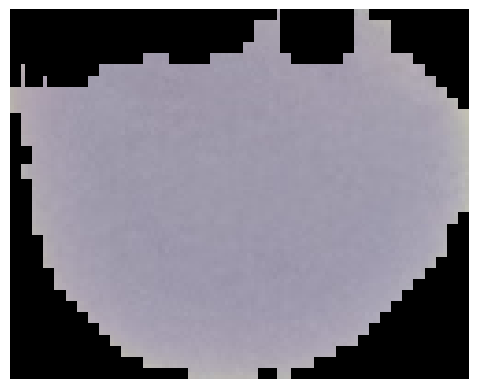

GT: Parasitized | Pred: Parasitized


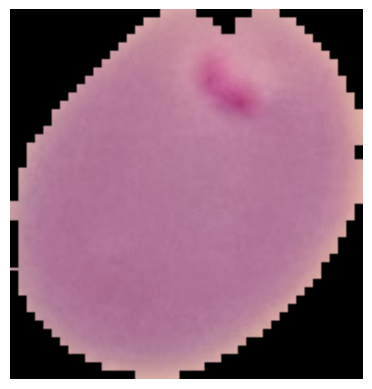

GT: Parasitized | Pred: Parasitized


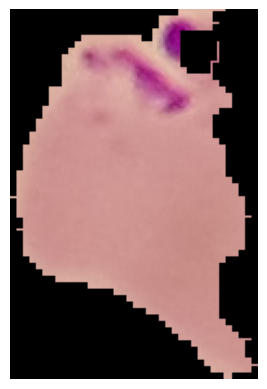

GT: Uninfected | Pred: Uninfected


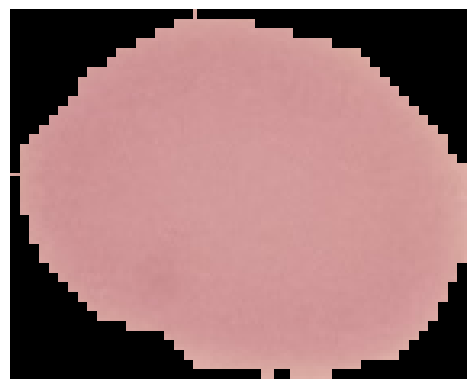

GT: Uninfected | Pred: Uninfected


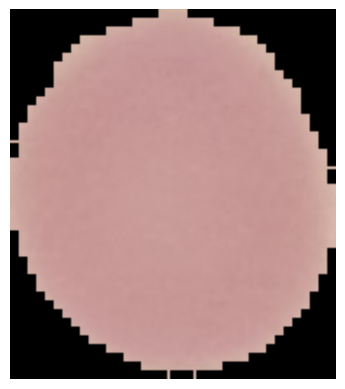

GT: Uninfected | Pred: Uninfected


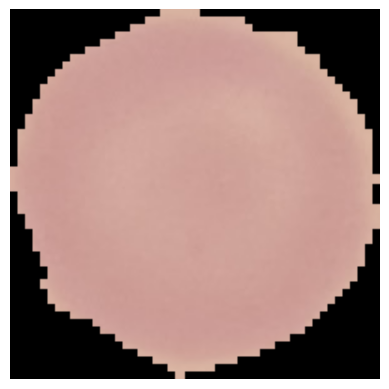

In [23]:
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

class_names = ['Parasitized', 'Uninfected']

# Colab paths
parasitized_paths = np.array(
    glob("/content/malaria_data/cell_images/Parasitized/*.png")
)
uninfected_paths = np.array(
    glob("/content/malaria_data/cell_images/Uninfected/*.png")
)

print("Found", len(parasitized_paths), "Parasitized images")
print("Found", len(uninfected_paths), "Uninfected images")

# show & predict 3 Parasitized images
for i in range(3):
    img_path = parasitized_paths[i]
    img = Image.open(img_path)

    pred_class = predict_malaria(model, class_names, img_path, device)
    print("GT: Parasitized | Pred:", pred_class)

    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# show & predict 3 Uninfected images
for i in range(3):
    img_path = uninfected_paths[i]
    img = Image.open(img_path)

    pred_class = predict_malaria(model, class_names, img_path, device)
    print("GT: Uninfected | Pred:", pred_class)

    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        else:
            data, target = data, target

        outputs = model(data)
        preds = outputs.argmax(dim=1)

        # move to CPU and convert to plain ints
        all_labels.extend(target.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

all_labels = np.array(all_labels, dtype=int)
all_preds = np.array(all_preds, dtype=int)

print("Classification report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("\nConfusion matrix:")
print(confusion_matrix(all_labels, all_preds))

Classification report:
              precision    recall  f1-score   support

 Parasitized       0.92      0.88      0.90      1349
  Uninfected       0.89      0.93      0.91      1407

    accuracy                           0.91      2756
   macro avg       0.91      0.91      0.91      2756
weighted avg       0.91      0.91      0.91      2756


Confusion matrix:
[[1193  156]
 [  99 1308]]


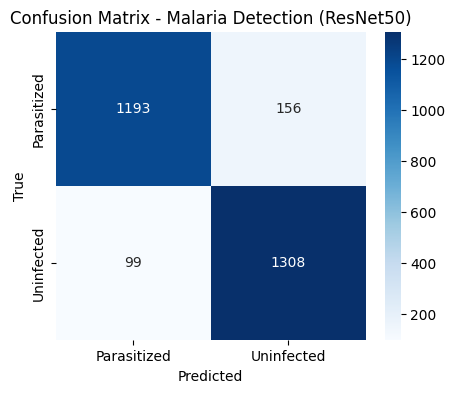

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Malaria Detection (ResNet50)")
plt.show()

# USER INPUT

In [26]:
# --- 1. Imports ---
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
from google.colab import files
import io

# --- 2. Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 3. Rebuild the same model and load weights ---
#   (must match what you used during training)
model = models.resnet50(weights=None)     # no pretrained weights now
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: Parasitized / Uninfected

# path where you saved earlier: save_path = "malaria_resnet50_best.pth"
state_dict = torch.load("/content/malaria_resnet50_best.pth", map_location=device)
model.load_state_dict(state_dict)

model.to(device)
model.eval()

class_names = ["Parasitized", "Uninfected"]

# --- 4. Image transform (same normalization as training) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

def preprocess_image(pil_img):
    tensor = transform(pil_img).unsqueeze(0)  # add batch dim
    return tensor.to(device)

# --- 5. Upload and predict ---
uploaded = files.upload()   # choose any cell image from your machine

for filename, data in uploaded.items():
    print(f"\nRunning prediction on: {filename}")

    img = Image.open(io.BytesIO(data)).convert("RGB")
    x = preprocess_image(img)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        pred_idx = int(torch.argmax(probs))
        pred_class = class_names[pred_idx]
        pred_prob = float(probs[pred_idx])

    print(f"Prediction: {pred_class}  (confidence: {pred_prob:.3f})")

Device: cuda


Saving Screenshot 2025-11-13 at 1.23.40 PM.png to Screenshot 2025-11-13 at 1.23.40 PM.png

Running prediction on: Screenshot 2025-11-13 at 1.23.40 PM.png
Prediction: Uninfected  (confidence: 0.572)


In [27]:
# --- 1. Imports ---
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
from google.colab import files
import io

# --- 2. Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 3. Rebuild the same model and load weights ---
#   (must match what you used during training)
model = models.resnet50(weights=None)     # no pretrained weights now
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: Parasitized / Uninfected

# path where you saved earlier: save_path = "malaria_resnet50_best.pth"
state_dict = torch.load("/content/malaria_resnet50_best.pth", map_location=device)
model.load_state_dict(state_dict)

model.to(device)
model.eval()

class_names = ["Parasitized", "Uninfected"]

# --- 4. Image transform (same normalization as training) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

def preprocess_image(pil_img):
    tensor = transform(pil_img).unsqueeze(0)  # add batch dim
    return tensor.to(device)

# --- 5. Upload and predict ---
uploaded = files.upload()   # choose any cell image from your machine

for filename, data in uploaded.items():
    print(f"\nRunning prediction on: {filename}")

    img = Image.open(io.BytesIO(data)).convert("RGB")
    x = preprocess_image(img)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        pred_idx = int(torch.argmax(probs))
        pred_class = class_names[pred_idx]
        pred_prob = float(probs[pred_idx])

    print(f"Prediction: {pred_class}  (confidence: {pred_prob:.3f})")

Device: cuda


Saving Screenshot 2025-11-13 at 1.23.44 PM.png to Screenshot 2025-11-13 at 1.23.44 PM.png

Running prediction on: Screenshot 2025-11-13 at 1.23.44 PM.png
Prediction: Uninfected  (confidence: 0.973)


In [28]:
# --- 1. Imports ---
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
from google.colab import files
import io

# --- 2. Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 3. Rebuild the same model and load weights ---
#   (must match what you used during training)
model = models.resnet50(weights=None)     # no pretrained weights now
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: Parasitized / Uninfected

# path where you saved earlier: save_path = "malaria_resnet50_best.pth"
state_dict = torch.load("/content/malaria_resnet50_best.pth", map_location=device)
model.load_state_dict(state_dict)

model.to(device)
model.eval()

class_names = ["Parasitized", "Uninfected"]

# --- 4. Image transform (same normalization as training) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

def preprocess_image(pil_img):
    tensor = transform(pil_img).unsqueeze(0)  # add batch dim
    return tensor.to(device)

# --- 5. Upload and predict ---
uploaded = files.upload()   # choose any cell image from your machine

for filename, data in uploaded.items():
    print(f"\nRunning prediction on: {filename}")

    img = Image.open(io.BytesIO(data)).convert("RGB")
    x = preprocess_image(img)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        pred_idx = int(torch.argmax(probs))
        pred_class = class_names[pred_idx]
        pred_prob = float(probs[pred_idx])

    print(f"Prediction: {pred_class}  (confidence: {pred_prob:.3f})")

Device: cuda


Saving Screenshot 2025-11-13 at 1.23.56 PM.png to Screenshot 2025-11-13 at 1.23.56 PM.png

Running prediction on: Screenshot 2025-11-13 at 1.23.56 PM.png
Prediction: Uninfected  (confidence: 0.840)


In [29]:
# --- 1. Imports ---
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
from google.colab import files
import io

# --- 2. Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 3. Rebuild the same model and load weights ---
#   (must match what you used during training)
model = models.resnet50(weights=None)     # no pretrained weights now
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: Parasitized / Uninfected

# path where you saved earlier: save_path = "malaria_resnet50_best.pth"
state_dict = torch.load("/content/malaria_resnet50_best.pth", map_location=device)
model.load_state_dict(state_dict)

model.to(device)
model.eval()

class_names = ["Parasitized", "Uninfected"]

# --- 4. Image transform (same normalization as training) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

def preprocess_image(pil_img):
    tensor = transform(pil_img).unsqueeze(0)  # add batch dim
    return tensor.to(device)

# --- 5. Upload and predict ---
uploaded = files.upload()   # choose any cell image from your machine

for filename, data in uploaded.items():
    print(f"\nRunning prediction on: {filename}")

    img = Image.open(io.BytesIO(data)).convert("RGB")
    x = preprocess_image(img)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        pred_idx = int(torch.argmax(probs))
        pred_class = class_names[pred_idx]
        pred_prob = float(probs[pred_idx])

    print(f"Prediction: {pred_class}  (confidence: {pred_prob:.3f})")

Device: cuda


Saving Screenshot 2025-11-13 at 1.24.00 PM.png to Screenshot 2025-11-13 at 1.24.00 PM.png

Running prediction on: Screenshot 2025-11-13 at 1.24.00 PM.png
Prediction: Parasitized  (confidence: 0.631)


In [30]:
# --- 1. Imports ---
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
from google.colab import files
import io

# --- 2. Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 3. Rebuild the same model and load weights ---
#   (must match what you used during training)
model = models.resnet50(weights=None)     # no pretrained weights now
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: Parasitized / Uninfected

# path where you saved earlier: save_path = "malaria_resnet50_best.pth"
state_dict = torch.load("/content/malaria_resnet50_best.pth", map_location=device)
model.load_state_dict(state_dict)

model.to(device)
model.eval()

class_names = ["Parasitized", "Uninfected"]

# --- 4. Image transform (same normalization as training) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

def preprocess_image(pil_img):
    tensor = transform(pil_img).unsqueeze(0)  # add batch dim
    return tensor.to(device)

# --- 5. Upload and predict ---
uploaded = files.upload()   # choose any cell image from your machine

for filename, data in uploaded.items():
    print(f"\nRunning prediction on: {filename}")

    img = Image.open(io.BytesIO(data)).convert("RGB")
    x = preprocess_image(img)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        pred_idx = int(torch.argmax(probs))
        pred_class = class_names[pred_idx]
        pred_prob = float(probs[pred_idx])

    print(f"Prediction: {pred_class}  (confidence: {pred_prob:.3f})")

Device: cuda


Saving Screenshot 2025-11-13 at 1.24.03 PM.png to Screenshot 2025-11-13 at 1.24.03 PM.png

Running prediction on: Screenshot 2025-11-13 at 1.24.03 PM.png
Prediction: Uninfected  (confidence: 0.949)


In [31]:
!ls -lh

total 766M
-rw-r--r-- 1 root root 676M Oct 14  2019  cell-images-for-detecting-malaria.zip
-rw-r--r-- 1 root root   71 Nov 13 18:03  kaggle.json
drwxr-xr-x 3 root root 4.0K Nov 13 18:03  malaria_data
-rw-r--r-- 1 root root  90M Nov 13 18:14  malaria_resnet50_best.pth
drwxr-xr-x 1 root root 4.0K Nov 12 14:30  sample_data
-rw-r--r-- 1 root root 161K Nov 13 18:24 'Screenshot 2025-11-13 at 1.23.40 PM.png'
-rw-r--r-- 1 root root 125K Nov 13 18:25 'Screenshot 2025-11-13 at 1.23.44 PM.png'
-rw-r--r-- 1 root root  83K Nov 13 18:25 'Screenshot 2025-11-13 at 1.23.56 PM.png'
-rw-r--r-- 1 root root  71K Nov 13 18:25 'Screenshot 2025-11-13 at 1.24.00 PM.png'
-rw-r--r-- 1 root root  54K Nov 13 18:26 'Screenshot 2025-11-13 at 1.24.03 PM.png'


In [32]:
from google.colab import files
files.download("malaria_resnet50_best.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>